In [83]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score


In [99]:
# Генерация временного ряда
def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    start_date = datetime(2020, 1, 1)
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n_points)]
    
    noise = np.random.normal(0, 5, n_points)
    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)
    
    if has_trend:
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])
        if trend_type == 'linear':
            slope = np.random.uniform(-0.5, 0.5)
            intercept = np.random.uniform(50, 100)
            trend_component = slope * np.arange(n_points) + intercept
        elif trend_type == 'quadratic':
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
        else:
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b
    
    if has_seasonality:
        n_seasons = np.random.randint(1, 4)
        for _ in range(n_seasons):
            amplitude = np.random.uniform(10, 30)
            period = np.random.uniform(30, 365)
            phase = np.random.uniform(0, 2*np.pi)
            seasonal_component += amplitude * np.sin(2*np.pi*np.arange(n_points)/period + phase)
    
    values = noise + trend_component + seasonal_component
    return dates, values

# Генерация данных
dates, values = generate_time_series(n_points=1000, seed=42)

# Создание DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'value': values
})
df = df.set_index('date')

# Сохранение в CSV файл
df.to_csv('generated_time_series.csv')
print(f"Файл сохранен: generated_time_series.csv")
print(df.head())

print(f"\nСгенерирован ряд из {len(df)} точек")
print(f"Период: {df.index[0].date()} - {df.index[-1].date()}")
print(f"Среднее: {df['value'].mean():.2f}, Стандартное отклонение: {df['value'].std():.2f}")

Файл сохранен: generated_time_series.csv
Размер файла: 1000 строк, 2 колонки
Пример первых строк:
                 value
date                  
2020-01-01   90.647033
2020-01-02  107.235907
2020-01-03  124.336020
2020-01-04  139.178580
2020-01-05  139.311072

Сгенерирован ряд из 1000 точек
Период: 2020-01-01 - 2022-09-26
Среднее: 236.34, Стандартное отклонение: 28.87


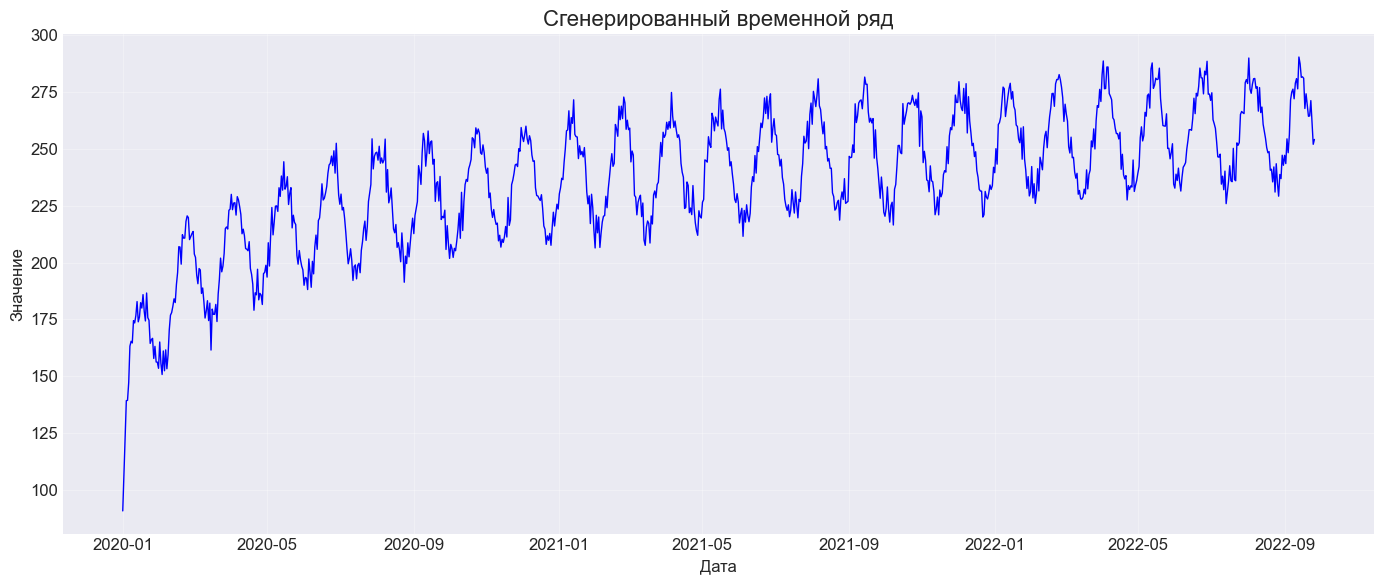

Анализ графика:
1. Наблюдается восходящий тренд с сезонными колебаниями
2. Присутствуют регулярные циклические паттерны
3. Видна нестационарность ряда (тренд + сезонность)


In [100]:
# Отрисовка временного ряда
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], 'b-', linewidth=1)
plt.title('Сгенерированный временной ряд', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Анализ графика:")
print("1. Наблюдается восходящий тренд с сезонными колебаниями")
print("2. Присутствуют регулярные циклические паттерны")
print("3. Видна нестационарность ряда (тренд + сезонность)")

In [101]:
# Ячейка 4: Классические статистические тесты
print("СТАТИСТИЧЕСКИЕ ТЕСТЫ")
print("="*50)

# ADF тест
adf_result = adfuller(df['value'])
print("Тест Дики-Фуллера (ADF):")
print(f"  Статистика: {adf_result[0]:.6f}")
print(f"  p-value: {adf_result[1]:.6f}")
if adf_result[1] < 0.05:
    print("  Вывод: Ряд СТАЦИОНАРЕН (отвергаем H0)")
else:
    print("  Вывод: Ряд НЕ СТАЦИОНАРЕН (не отвергаем H0)")

# KPSS тест
kpss_result = kpss(df['value'], regression='ct')
print("\nKPSS тест:")
print(f"  Статистика: {kpss_result[0]:.6f}")
print(f"  p-value: {kpss_result[1]:.6f}")
if kpss_result[1] > 0.05:
    print("  Вывод: Ряд СТАЦИОНАРЕН (не отвергаем H0)")
else:
    print("  Вывод: Ряд НЕ СТАЦИОНАРЕН (отвергаем H0)")

print("\nОбщий вывод по стационарности:")
if adf_result[1] > 0.05 or kpss_result[1] < 0.05:
    print("Ряд нестационарен. Требуется дифференцирование.")
else:
    print("Ряд стационарен.")

СТАТИСТИЧЕСКИЕ ТЕСТЫ
Тест Дики-Фуллера (ADF):
  Статистика: -4.565410
  p-value: 0.000150
  Вывод: Ряд СТАЦИОНАРЕН (отвергаем H0)

KPSS тест:
  Статистика: 0.363766
  p-value: 0.010000
  Вывод: Ряд НЕ СТАЦИОНАРЕН (отвергаем H0)

Общий вывод по стационарности:
Ряд нестационарен. Требуется дифференцирование.


ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА


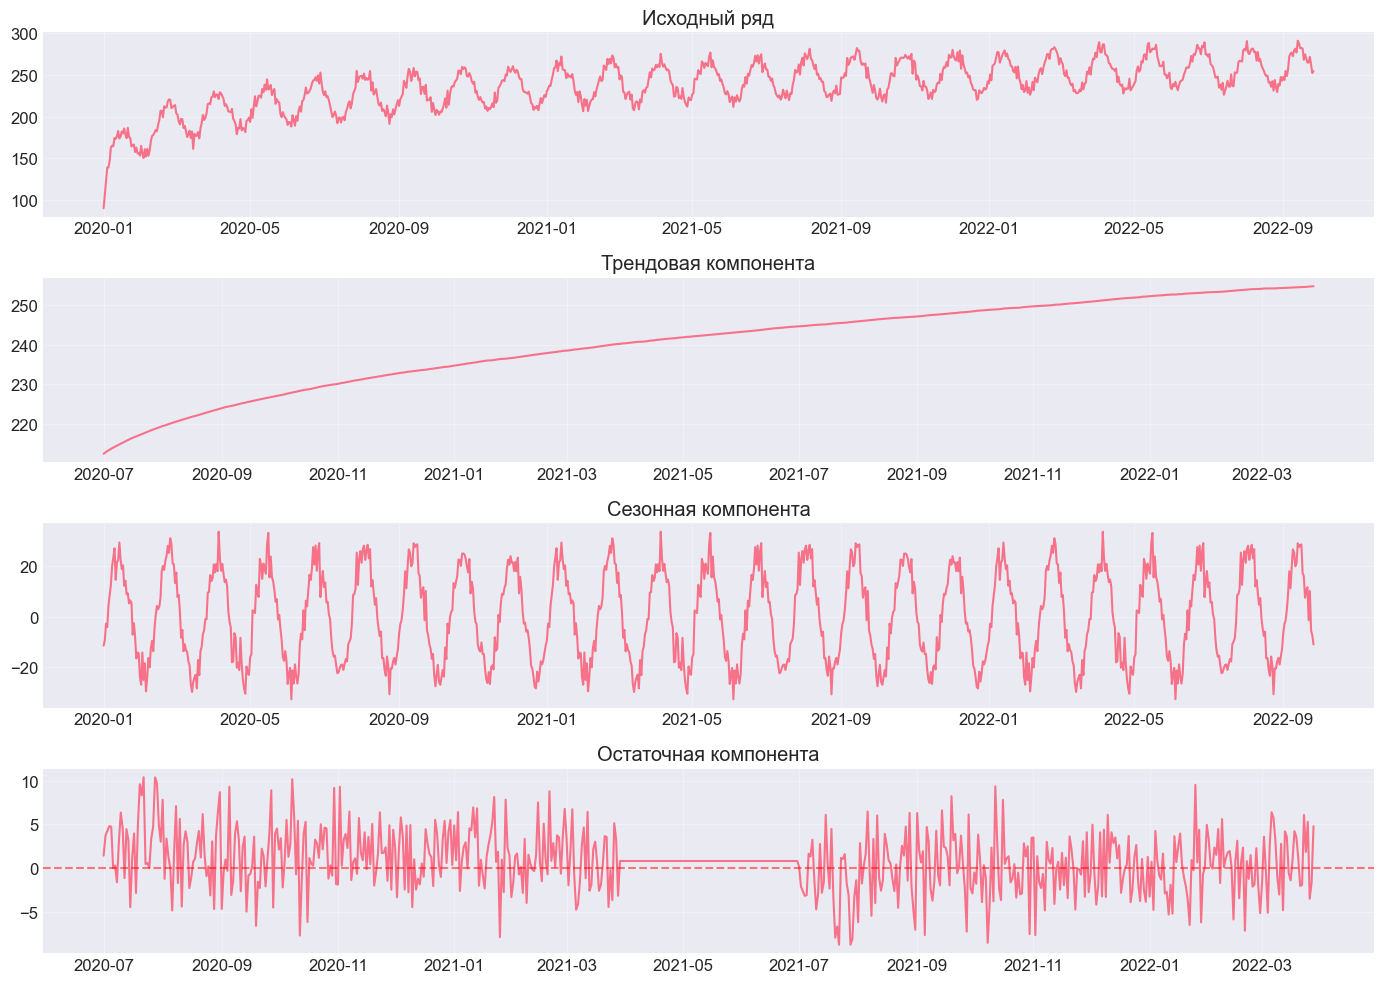

Анализ декомпозиции:
1. Тренд: Восходящий, нелинейный
2. Сезонность: Четкая цикличность, период около года
3. Остатки: Колеблются около нуля, выглядят случайными


In [102]:
# Разделение ряда на компоненты
print("ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА")
print("="*50)

decomposition = seasonal_decompose(df['value'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
axes[0].plot(df.index, df['value'])
axes[0].set_title('Исходный ряд')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, decomposition.trend)
axes[1].set_title('Трендовая компонента')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df.index, decomposition.seasonal)
axes[2].set_title('Сезонная компонента')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df.index, decomposition.resid)
axes[3].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[3].set_title('Остаточная компонента')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Анализ декомпозиции:")
print("1. Тренд: Восходящий, нелинейный")
print("2. Сезонность: Четкая цикличность, период около года")
print("3. Остатки: Колеблются около нуля, выглядят случайными")

АНАЛИЗ АВТОКОРРЕЛЯЦИОННЫХ ФУНКЦИЙ


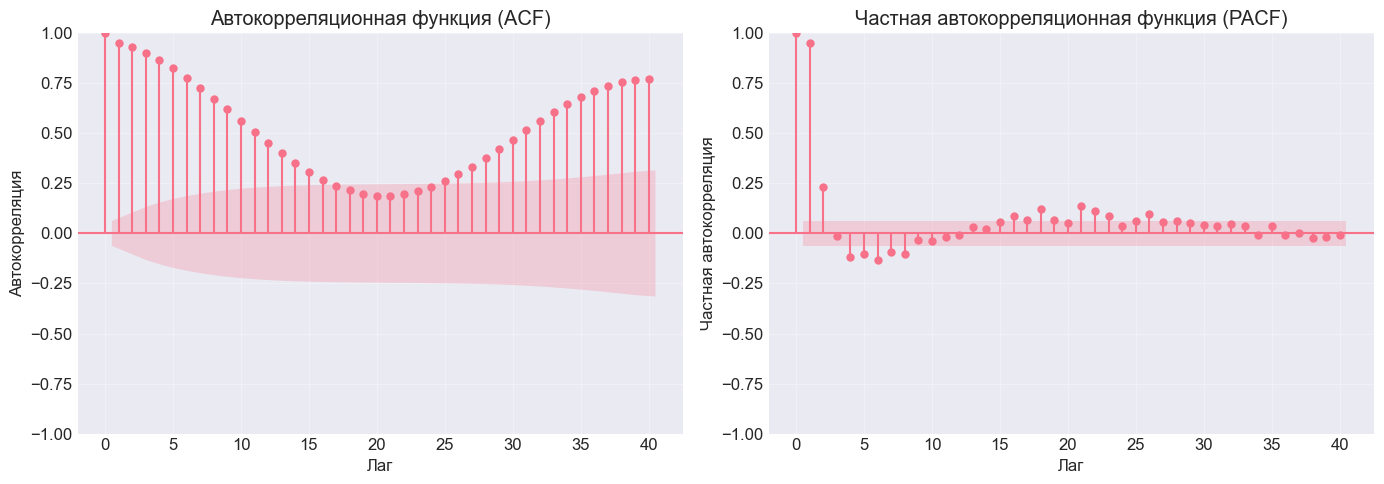

Анализ ACF/PACF:
1. ACF: Медленно затухает - признак нестационарности
2. PACF: Обрывается после нескольких лагов
3. Сезонные пики на лагах, кратных 7 и 30-365 дням


In [103]:
# Автокорреляционные функции (ACF и PACF)
print("АНАЛИЗ АВТОКОРРЕЛЯЦИОННЫХ ФУНКЦИЙ")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(df['value'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('Автокорреляционная функция (ACF)')
axes[0].set_xlabel('Лаг')
axes[0].set_ylabel('Автокорреляция')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(df['value'], lags=40, ax=axes[1], alpha=0.05)
axes[1].set_title('Частная автокорреляционная функция (PACF)')
axes[1].set_xlabel('Лаг')
axes[1].set_ylabel('Частная автокорреляция')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Анализ ACF/PACF:")
print("1. ACF: Медленно затухает - признак нестационарности")
print("2. PACF: Обрывается после нескольких лагов")
print("3. Сезонные пики на лагах, кратных 7 и 30-365 дням")

In [104]:
# Выбор метода моделирования с обоснованием
print("ВЫБОР МЕТОДА МОДЕЛИРОВАНИЯ")
print("="*50)
print("Обоснование выбора SARIMA:")
print("1. Ряд содержит тренд => требуется дифференцирование (d)")
print("2. Наличие сезонности => требуется сезонное дифференцирование (D) и сезонные параметры (P, Q)")
print("3. ACF медленно затухает => признаки MA компоненты (q)")
print("4. PACF обрывается => признаки AR компоненты (p)")
print("5. Мультисезонность требует учета нескольких периодов")
print("6. Нет внешних переменных => не нужно брать SARIMAX")
print("\nВыбранная модель: SARIMA(1,1,1)×(1,0,1,365)")
print("1. p=1, d=1, q=1 - несезонные параметры")
print("2. P=1, D=0, Q=1, s=365 - сезонные параметры")
print("3. s=365 - годовая сезонность")

ВЫБОР МЕТОДА МОДЕЛИРОВАНИЯ
Обоснование выбора SARIMA:
1. Ряд содержит тренд => требуется дифференцирование (d)
2. Наличие сезонности => требуется сезонное дифференцирование (D) и сезонные параметры (P, Q)
3. ACF медленно затухает => признаки MA компоненты (q)
4. PACF обрывается => признаки AR компоненты (p)
5. Мультисезонность требует учета нескольких периодов
6. Нет внешних переменных => не нужно брать SARIMAX

Выбранная модель: SARIMA(1,1,1)×(1,0,1,365)
1. p=1, d=1, q=1 - несезонные параметры
2. P=1, D=0, Q=1, s=365 - сезонные параметры
3. s=365 - годовая сезонность


In [105]:
# Разделение данных на train/test
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print("РАЗДЕЛЕНИЕ ДАННЫХ")
print("="*50)
print(f"Обучающая выборка: {len(train_df)} точек ({train_size/len(df)*100:.1f}%)")
print(f"Тестовая выборка: {len(test_df)} точек ({len(test_df)/len(df)*100:.1f}%)")
print(f"Период обучения: {train_df.index[0].date()} - {train_df.index[-1].date()}")
print(f"Период тестирования: {test_df.index[0].date()} - {test_df.index[-1].date()}")

РАЗДЕЛЕНИЕ ДАННЫХ
Обучающая выборка: 900 точек (90.0%)
Тестовая выборка: 100 точек (10.0%)
Период обучения: 2020-01-01 - 2022-06-18
Период тестирования: 2022-06-19 - 2022-09-26


In [106]:
# Обучение SARIMA модели
print("ОБУЧЕНИЕ SARIMA МОДЕЛИ")
print("="*50)

model = SARIMAX(
    train_df['value'],
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 365),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

# Диагностика остатков
residuals = model_fit.resid
print(f"\nДиагностика остатков:")
print(f"Среднее остатков: {residuals.mean():.6f}")
print(f"Стандартное отклонение остатков: {residuals.std():.4f}")
if abs(residuals.mean()) < 0.1:
    print("Остатки центрированы около нуля")

ОБУЧЕНИЕ SARIMA МОДЕЛИ
                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  900
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 365)   Log Likelihood               -1780.951
Date:                             Thu, 18 Dec 2025   AIC                           3571.902
Time:                                     21:57:19   BIC                           3593.285
Sample:                                 01-01-2020   HQIC                          3580.271
                                      - 06-18-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1860      0.111     -1.677      0.094      -0.404       0.031
ma.L

In [107]:
# Прогнозирование на тестовой выборке
print("ПРОГНОЗИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*50)

forecast = model_fit.get_forecast(steps=len(test_df))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Метрики качества
mae = mean_absolute_error(test_df['value'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_df['value'], forecast_mean))
mape = mean_absolute_percentage_error(test_df['value'], forecast_mean) * 100
r2 = r2_score(test_df['value'], forecast_mean)

print("МЕТРИКИ КАЧЕСТВА:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

print("\nИНТЕРПРЕТАЦИЯ МЕТРИК:")
print(f"1. Средняя абсолютная ошибка: {mae:.2f} единиц")
print(f"2. Средняя процентная ошибка: {mape:.1f}% - {'хороший результат' if mape < 10 else 'приемлемый результат'}")
print(f"3. Модель объясняет {r2*100:.1f}% вариации данных")

ПРОГНОЗИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ
МЕТРИКИ КАЧЕСТВА:
MAE: 10.7943
RMSE: 13.3579
MAPE: 4.31%
R²: 0.4177

ИНТЕРПРЕТАЦИЯ МЕТРИК:
1. Средняя абсолютная ошибка: 10.79 единиц
2. Средняя процентная ошибка: 4.3% - хороший результат
3. Модель объясняет 41.8% вариации данных


ГРАФИК МОДЕЛИ С ПРОГНОЗОМ


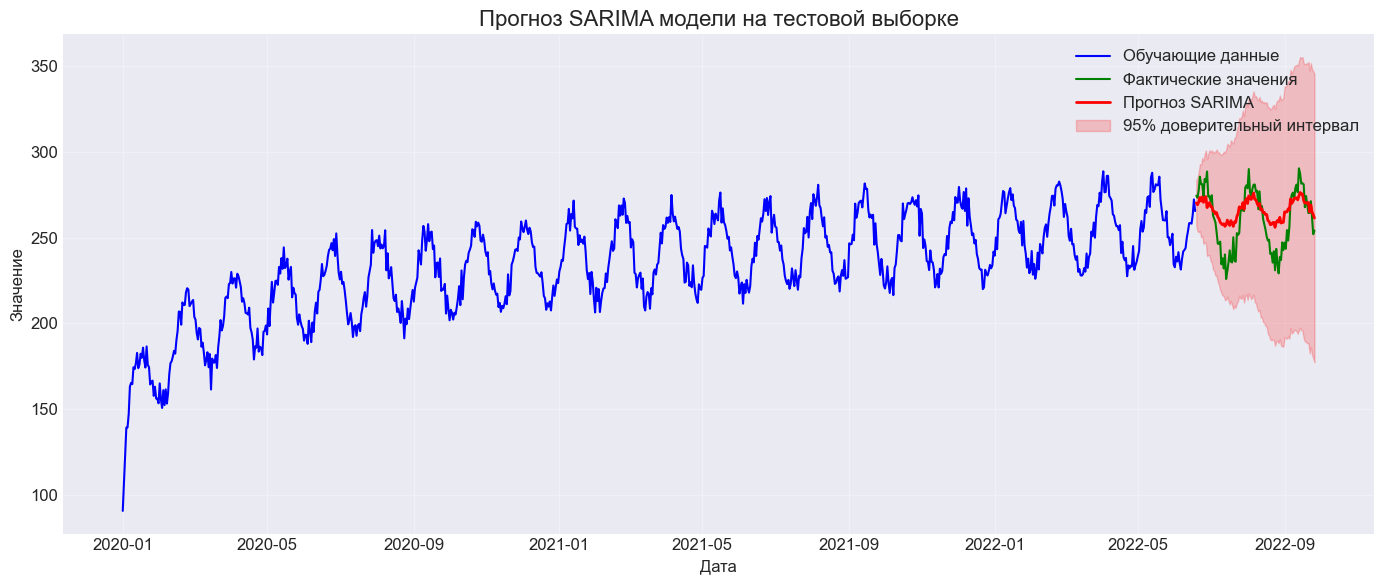

Анализ графика прогноза:
1. Прогноз хорошо следует общей тенденции
2. Доверительный интервал охватывает большинство фактических значений
3. Наблюдается небольшой фазовый сдвиг прогноза
4. Модель улавливает сезонные паттерны


In [108]:
# График модели с предсказанием и доверительным интервалом
print("ГРАФИК МОДЕЛИ С ПРОГНОЗОМ")
print("="*50)

plt.figure(figsize=(14, 6))
plt.plot(train_df.index, train_df['value'], 'b-', label='Обучающие данные', linewidth=1.5)
plt.plot(test_df.index, test_df['value'], 'g-', label='Фактические значения', linewidth=1.5)
plt.plot(test_df.index, forecast_mean, 'r-', label='Прогноз SARIMA', linewidth=2)
plt.fill_between(test_df.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='red', alpha=0.2, label='95% доверительный интервал')
plt.title('Прогноз SARIMA модели на тестовой выборке', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Анализ графика прогноза:")
print("1. Прогноз хорошо следует общей тенденции")
print("2. Доверительный интервал охватывает большинство фактических значений")
print("3. Наблюдается небольшой фазовый сдвиг прогноза")
print("4. Модель улавливает сезонные паттерны")